In [70]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from pipeline import Dataset
from datatools import data_quantization, extract_market_data
from pipeline.backtest import cross_validation
from visualize.metric import plot_performance

In [69]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
dataset = Dataset.load('../../data/parsed')

In [89]:
quantized_fundamental, _ = data_quantization(dataset.fundamental.set_index(['day', 'asset']))

In [90]:
df = pd.concat(
    [quantized_fundamental,
     dataset.ref_return.set_index(['day','asset'])], axis=1).dropna()

In [47]:
quantile_feature = ['turnoverRatio_QUANTILE', 'transactionAmount_QUANTILE', 'pb_QUANTILE', 'ps_QUANTILE',
                    'pe_ttm_QUANTILE', 'pe_QUANTILE', 'pcf_QUANTILE']

In [ ]:
def linear_model(X, y):
    reg = LinearRegression().fit(X, y)
    return reg

In [80]:
performance_old = cross_validation(linear_model, quantile_feature, df=df, n_splits=997, lookback_window=200)

  0%|          | 0/997 [00:00<?, ?it/s]

The ending score for metric train_r2 is:  0.003203874074728885
The ending score for metric val_cum_pearson is:  0.04262209568161889


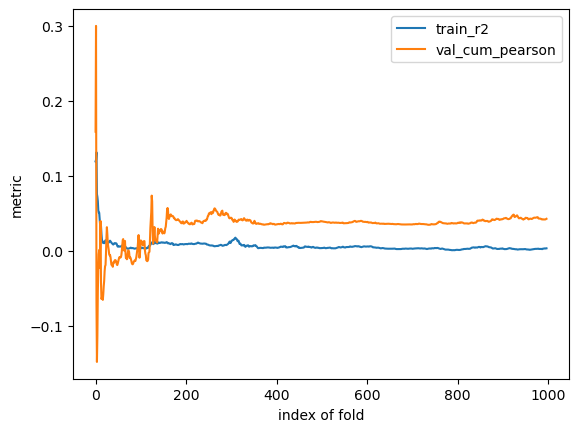

In [83]:
plt.figure()
plot_performance(performance_old, metrics_selected=['train_r2', 'val_cum_pearson'])
plt.show()


In [88]:
m_df = dataset.market.set_index(['day', 'asset', 'timeslot'])
m_df.head()

open    close     high      low    volume         money
day asset timeslot                                                            
1   0     1         25.0164  24.9557  25.1378  24.9436  642243.0  1.610060e+07
    1     1         16.3256  16.3499  16.4106  16.3256   15552.0  2.540301e+05
    2     1          9.2006   9.1763   9.2006   9.1521  396647.0  3.638304e+06
    3     1          9.1521   9.2006   9.2006   9.1521  317044.0  2.907092e+06
    4     1          5.1829   5.1222   5.1829   5.1101  294784.0  1.514496e+06

In [ ]:
m_df_day = extract_market_data(m_df)
m_df_day.head()

In [27]:
m_df_day = m_df_day.swaplevel()
m_df_day.head()

,,avg_price,volatility,mean_volume
asset,day,,,
0,1,24.553713,0.861989,454075.84
1,1,16.169781,0.804576,176868.36
2,1,9.059178,0.351893,361648.66
3,1,9.124460,0.250697,351809.54
4,1,5.054415,0.270981,338476.86


In [52]:
m_df_day_quant, _ = data_quantization(m_df_day)

In [63]:
df_mk = pd.concat([m_df_day_quant, df], axis=1).dropna()
df_mk.head()

,,avg_price_QUANTILE,volatility_QUANTILE,mean_volume_QUANTILE,turnoverRatio_QUANTILE,transactionAmount_QUANTILE,pe_ttm_QUANTILE,pe_QUANTILE,pb_QUANTILE,ps_QUANTILE,pcf_QUANTILE,return
asset,day,,,,,,,,,,,
0,1,8,6,8,9.0,9.0,6.0,6.0,6.0,5.0,1.0,-0.026877
1,1,6,6,6,9.0,3.0,4.0,4.0,6.0,5.0,5.0,-0.052674
2,1,3,3,8,7.0,4.0,7.0,7.0,6.0,6.0,3.0,-0.002691
3,1,3,2,8,8.0,2.0,1.0,1.0,2.0,1.0,7.0,-0.018515
4,1,1,2,8,5.0,4.0,1.0,1.0,3.0,4.0,4.0,-0.019184


In [55]:
new_feature = quantile_feature+m_df_day_quant.columns.tolist()

In [64]:
performance = cross_validation(linear_model, new_feature, df=df_mk, n_splits=997, lookback_window=200)

  0%|          | 0/997 [00:00<?, ?it/s]

0.004443609592435838
0.03719482583241822


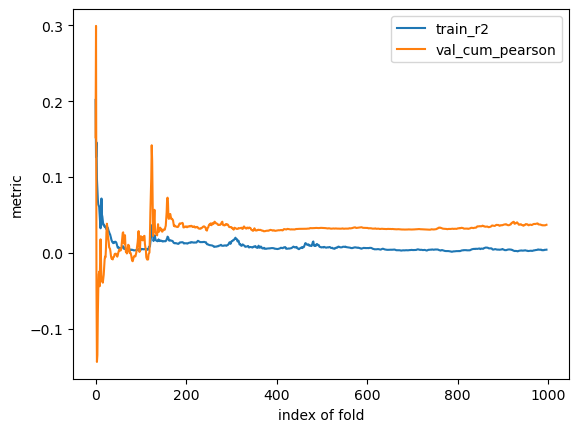

In [79]:
plt.figure()
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson'])
plt.show()


,,turnoverRatio,transactionAmount,pe_ttm,pe,pb,ps,pcf
asset,day,,,,,,,
0,1,3.6794,17229.0,34.4425,32.3029,4.9425,3.8180,-578.7700
1,1,2.5150,3706.0,28.9934,27.2726,5.0552,3.0484,23.8260
2,1,1.2858,5136.0,42.9352,41.9279,4.8083,4.1392,-58.2185
3,1,2.2007,3280.0,15.2245,13.8032,2.1904,0.6691,61.0491
4,1,0.8627,5291.0,-369.9850,-433.1736,3.0714,2.9370,-25.2279
